In [1]:
import QuantLib as ql
import math
import numpy as np
import pandas_datareader as web
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('seaborn')

## 從yahoo finance 匯入台灣加權股價指數

In [2]:
df = web.DataReader('^TWII', data_source = 'yahoo', start = '2018-11-21', end = '2020-11-18')

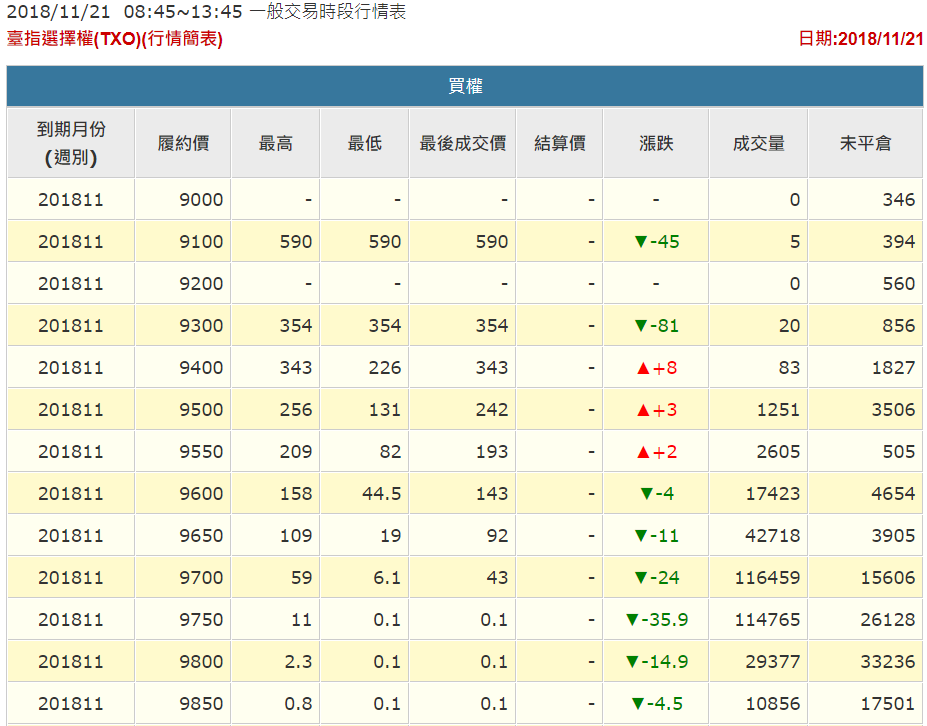

In [3]:
day_count = ql.Actual365Fixed()
calendar = ql.Taiwan()

calculation_date = ql.Date(21, 11, 2018) #from 2018/11/21 to 2020/11/18

spot = df.loc['2018-11-21']['Close']
ql.Settings.instance().evaluationDate = calculation_date

dividend_yield = ql.QuoteHandle(ql.SimpleQuote(0.0))
risk_free_rate = 0.01
dividend_rate = 0.0
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)) #construct risk-free rate termstructure
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)) #construct dividend rate termstructure

In [4]:
#每月的第3個禮拜三為到期日
expiration_dates = [ql.Date(19,12,2018), ql.Date(16,1,2019), ql.Date(20,2,2019),
                    ql.Date(20,3,2019), ql.Date(17,4,2019), ql.Date(15,5,2019), 
                    ql.Date(12,6,2019), ql.Date(17,7,2019), ql.Date(21,8,2019),
                    ql.Date(18,9,2019), ql.Date(16,10,2019), ql.Date(20,11,2019), 
                    ql.Date(18,12,2019), ql.Date(15,1,2020), ql.Date(19,2,2020),
                    ql.Date(18,3,2020), ql.Date(15,4,2020), ql.Date(20,5,2020), 
                    ql.Date(17,6,2020), ql.Date(15,7,2020), ql.Date(19,8,2020),
                    ql.Date(16,9,2020), ql.Date(21,10,2020), ql.Date(18,11,2020)]
strikes = [9000.00, 9100.00, 9200.00, 9300.00, 9400.00, 9500.00, 9600.00, 9700.00]
data = [
[0.37819, 0.34177, 0.30394, 0.27832, 0.26453, 0.25916, 0.25941, 0.26127],
[0.3445, 0.31769, 0.2933, 0.27614, 0.26575, 0.25729, 0.25228, 0.25202],
[0.37419, 0.35372, 0.33729, 0.32492, 0.31601, 0.30883, 0.30036, 0.29568],
[0.37498, 0.35847, 0.34475, 0.33399, 0.32715, 0.31943, 0.31098, 0.30506],
[0.35941, 0.34516, 0.33296, 0.32275, 0.31867, 0.30969, 0.30239, 0.29631],
[0.35521, 0.34242, 0.33154, 0.3219, 0.31948, 0.31096, 0.30424, 0.2984],
[0.35442, 0.34267, 0.33288, 0.32374, 0.32245, 0.31474, 0.30838, 0.30283],
[0.35384, 0.34286, 0.33386, 0.32507, 0.3246, 0.31745, 0.31135, 0.306],
[0.35338, 0.343, 0.33464, 0.32614, 0.3263, 0.31961, 0.31371, 0.30852],
[0.35301, 0.34312, 0.33526, 0.32698, 0.32766, 0.32132, 0.31558, 0.31052],
[0.35272, 0.34322, 0.33574, 0.32765, 0.32873, 0.32267, 0.31705, 0.31209],
[0.35246, 0.3433, 0.33617, 0.32822, 0.32965, 0.32383, 0.31831, 0.31344],
[0.35226, 0.34336, 0.33651, 0.32869, 0.3304, 0.32477, 0.31934, 0.31453],
[0.35207, 0.34342, 0.33681, 0.32911, 0.33106, 0.32561, 0.32025, 0.3155],
[0.35171, 0.34327, 0.33679, 0.32931, 0.3319, 0.32665, 0.32139, 0.31675],
[0.35128, 0.343, 0.33658, 0.32937, 0.33276, 0.32769, 0.32255, 0.31802],
[0.35086, 0.34274, 0.33637, 0.32943, 0.3336, 0.32872, 0.32368, 0.31927],
[0.35049, 0.34252, 0.33618, 0.32948, 0.33432, 0.32959, 0.32465, 0.32034],
[0.35016, 0.34231, 0.33602, 0.32953, 0.33498, 0.3304, 0.32554, 0.32132],
[0.34986, 0.34213, 0.33587, 0.32957, 0.33556, 0.3311, 0.32631, 0.32217],
[0.34959, 0.34196, 0.33573, 0.32961, 0.3361, 0.33176, 0.32704, 0.32296],
[0.34934, 0.34181, 0.33561, 0.32964, 0.33658, 0.33235, 0.32769, 0.32368],
[0.34912, 0.34167, 0.3355, 0.32967, 0.33701, 0.33288, 0.32827, 0.32432],
[0.34891, 0.34154, 0.33539, 0.3297, 0.33742, 0.33337, 0.32881, 0.32492]]

## Implied Volatility Surface

In [5]:
implied_vols = ql.Matrix(len(strikes), len(expiration_dates))
for i in range(implied_vols.rows()):
    for j in range(implied_vols.columns()):
        implied_vols[i][j] = data[j][i]

volatility surface can be constructed using the BlackVarianceSurface method.

In [6]:
black_var_surface = ql.BlackVarianceSurface(
    calculation_date, calendar, 
    expiration_dates, strikes, 
    implied_vols, day_count)

given any strike price and expiry can get the volatility

In [7]:
strike = 9100.0
expiry = 1.0 # years
black_var_surface.blackVol(expiry, strike)

0.343339871166861

### construct volatility smile

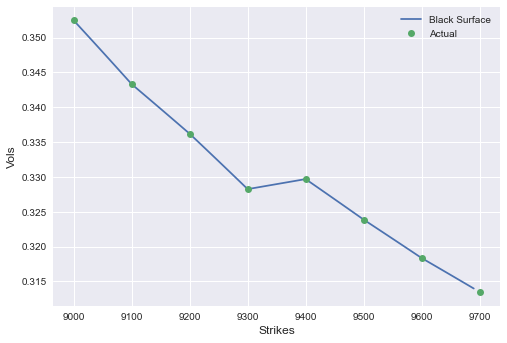

In [8]:
strikes_grid = np.arange(strikes[0], strikes[-1],10)
expiry = 1.0 # years
implied_vols = [black_var_surface.blackVol(expiry, s) 
                for s in strikes_grid] 
actual_data = data[11] 

fig, ax = plt.subplots()
ax.plot(strikes_grid, implied_vols, label="Black Surface")
ax.plot(strikes, actual_data, "o", label="Actual")
ax.set_xlabel("Strikes", size=12)
ax.set_ylabel("Vols", size=12)
legend = ax.legend(loc="upper right")

### the whole volatility surface

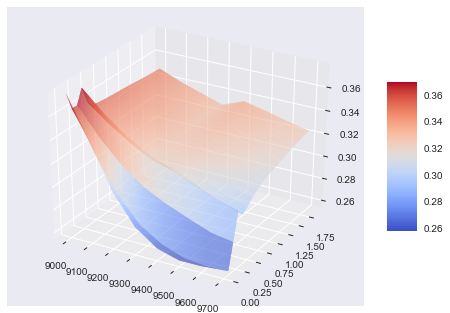

In [9]:
plot_years = np.arange(0, 2, 0.1)
plot_strikes = np.arange(9001, 9700, 1)
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_years)
Z = np.array([black_var_surface.blackVol(float(y), float(x)) 
              for xr, yr in zip(X, Y) 
                  for x, y in zip(xr,yr) ]
             ).reshape(len(X), len(X[0]))

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

In [10]:
local_vol_surface = ql.LocalVolSurface(
    ql.BlackVolTermStructureHandle(black_var_surface), 
    flat_ts, 
    dividend_ts, 
    spot)

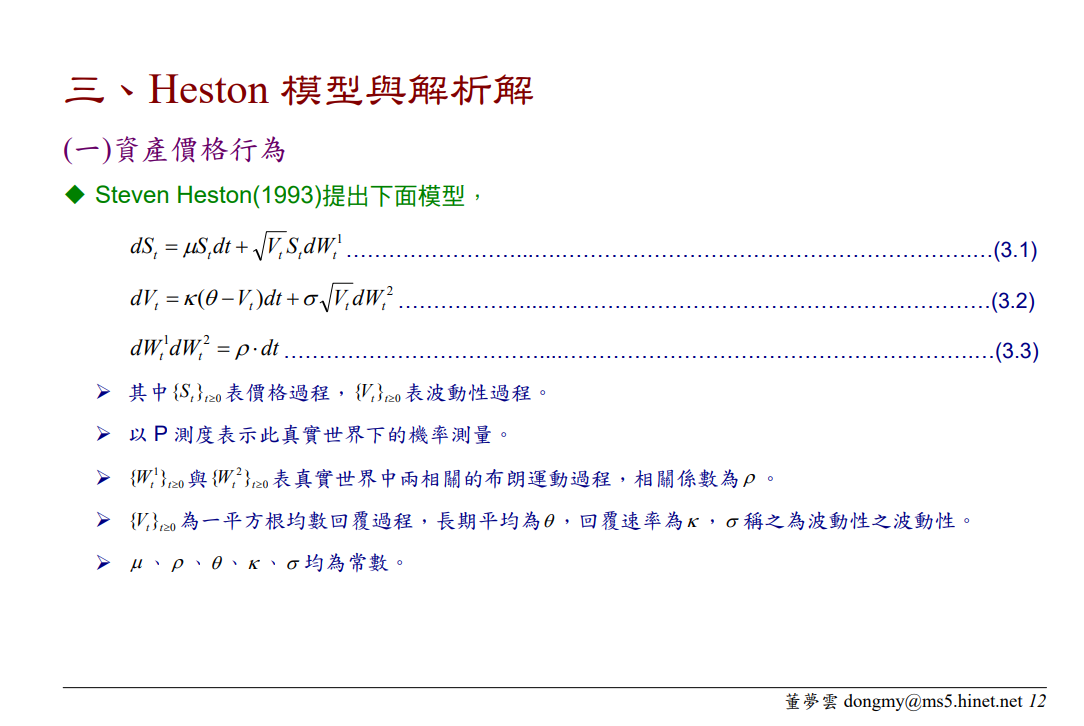

### calibrate the Heston Model

In [11]:
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; sigma = 0.5;

process = ql.HestonProcess(flat_ts, dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(spot)), 
                           v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process) #construct Heston Model
engine = ql.AnalyticHestonEngine(model) # construct pricing engine

* then we have the Hetson model and pricing engine
* 選擇所有strike price 還有一年maturity to calibrate the Heson model

In [12]:
heston_helpers = []
black_var_surface.setInterpolation("bicubic")
one_year_idx = 11 
date = expiration_dates[one_year_idx]
for j, s in enumerate(strikes):
    t = (date - calculation_date )
    p = ql.Period(t, ql.Days)
    sigma = data[one_year_idx][j] #sigma = black_var_surface.blackVol(t/365.25, s)
   
    helper = ql.HestonModelHelper(p, calendar, spot, s, 
                                  ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                  flat_ts, 
                                  dividend_ts)
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

In [13]:
lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm, 
                 ql.EndCriteria(500, 50, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()

In [14]:
print("theta = {}, kappa = {}, sigma = {}, rho = {}, v0 = {}".format(theta, kappa, sigma, rho, v0))

theta = 0.1435086943220949, kappa = 2.149809280806962, sigma = 0.10000619553604377, rho = -0.9999995896777616, v0 = 0.030767452780416215


In [15]:
avg = 0.0

print ("%15s %15s %15s %20s" % (
    "Strikes", "Market Value", 
     "Model Value", "Relative Error (%)"))
print("="*70)
for i, opt in enumerate(heston_helpers):
    err = (opt.modelValue()/opt.marketValue() - 1.0)
    print("%15.2f %14.5f %15.5f %20.7f " % (
        strikes[i], opt.marketValue(), 
        opt.modelValue(), 
        100.0*(opt.modelValue()/opt.marketValue() - 1.0)))
    avg += abs(err)
avg = avg*100.0/len(heston_helpers)
print("-" * 70)
print ("Average Abs Error (%%) : %5.3f" % (avg))

        Strikes    Market Value     Model Value   Relative Error (%)
        9000.00     1175.74319      1082.47993           -7.9322816 
        9100.00     1185.55000      1129.51708           -4.7263224 
        9200.00     1204.43866      1177.61387           -2.2271617 
        9300.00     1220.10195      1226.76171            0.5458363 
        9400.00     1278.08406      1276.95148           -0.0886156 
        9500.00     1304.53643      1328.17351            1.8119144 
        9600.00     1332.96946      1380.41761            3.5595825 
        9700.00     1365.05515      1433.67313            5.0267558 
----------------------------------------------------------------------
Average Abs Error (%) : 3.240
